In [1]:
from scipy.cluster.vq import whiten
from scipy.cluster.vq import kmeans
import numpy as np
import matplotlib.pyplot as plt

In [2]:
obs = np.array([
    [1, 5],
    [3, 7],
    [5, 10],
    [7, 7],
    [10, 5],
    [7, 3],
    [5, 1],
    [3, 3]
])
obs[:, 1] *= 10

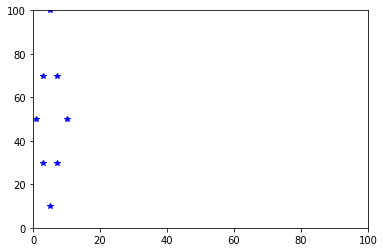

In [5]:
max_val = obs.max()
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.plot(obs[:, 0], obs[:, 1], "b*")

In [20]:
norm_obs = obs / obs.std(axis=0)
norm_obs

array([[0.37504578, 1.87522892],
       [1.12513735, 2.62532049],
       [1.87522892, 3.75045785],
       [2.62532049, 2.62532049],
       [3.75045785, 1.87522892],
       [2.62532049, 1.12513735],
       [1.87522892, 0.37504578],
       [1.12513735, 1.12513735]])

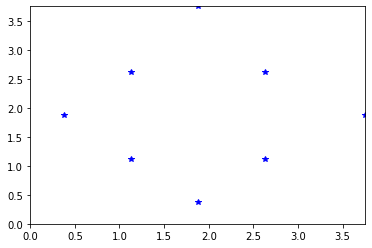

In [7]:
max_val = norm_obs.max()
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.plot(norm_obs[:, 0], norm_obs[:, 1], "b*")

In [10]:
np.sqrt(((obs[0] - obs[3]) ** 2).sum())

20.8806130178211

In [11]:
np.sqrt(((obs[0] - obs[4]) ** 2).sum())

9.0

# Norm过后的距离

In [12]:
np.sqrt(((norm_obs[0] - norm_obs[3]) ** 2).sum())

2.3719978133155237

In [13]:
np.sqrt(((norm_obs[0] - norm_obs[4]) ** 2).sum())

3.375412062757167

In [14]:
# feat = [年份(1995-2021)，房价(5w-15w)，幸福指数(0-1)]
#          2021,          150000,       0.1
#          2021,          150000,       1.0

In [15]:
# feat = [年份(1995-2021)，房价(5w-15w)，幸福指数(0-1)]
#          2021,          150100,       0.1
#          2021,          150000,       0.1

In [16]:
norm_obs

array([[0.37504578, 1.87522892],
       [1.12513735, 2.62532049],
       [1.87522892, 3.75045785],
       [2.62532049, 2.62532049],
       [3.75045785, 1.87522892],
       [2.62532049, 1.12513735],
       [1.87522892, 0.37504578],
       [1.12513735, 1.12513735]])

In [18]:
whiten(obs)

array([[0.37504578, 1.87522892],
       [1.12513735, 2.62532049],
       [1.87522892, 3.75045785],
       [2.62532049, 2.62532049],
       [3.75045785, 1.87522892],
       [2.62532049, 1.12513735],
       [1.87522892, 0.37504578],
       [1.12513735, 1.12513735]])

# Kmeans的使用

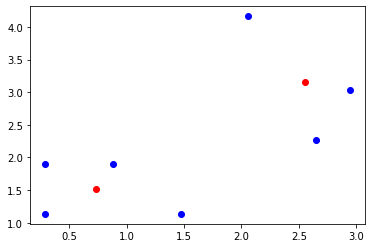

In [24]:
obs = np.array([
    [1, 5],
    [5, 3],
    [1, 3],
    [3, 5],
    [10, 8],
    [7, 11],
    [9, 6]
])

whitened = whiten(obs)
codebook, _ = kmeans(whitened, 2, iter=20)

plt.scatter(whitened[:, 0], whitened[:, 1], c="b")
plt.scatter(codebook[:, 0], codebook[:, 1], c="r")
plt.show()

# 写一遍Kmeans

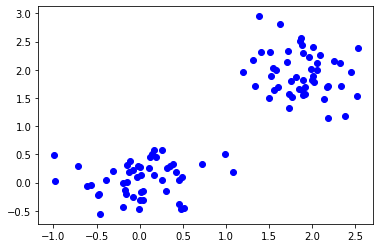

In [25]:
data = np.random.randn(100, 2)
data[:50] += 5.0

data = data / data.std(0)
plt.scatter(data[:, 0], data[:, 1], c="b")

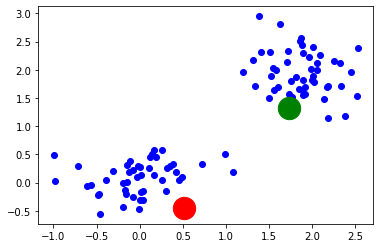

In [47]:
k = 2
#center_index = [0, 55]
center_index = np.random.choice(np.arange(len(data)), k)
center = data[center_index]
plt.scatter(data[:, 0], data[:, 1], c="b")
plt.scatter(center[0, 0], center[0, 1], c="r", s=500)
plt.scatter(center[1, 0], center[1, 1], c="g", s=500)

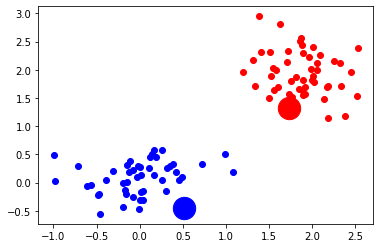

In [48]:
def dispatch(data, center):
    
    # data   ->  N x 2
    # center ->  K x 2
    data = data[:, None]  # N x 1 x 2
    center = center[None] # 1 x K x 2
    
    # N x K
    distance = ((data - center) ** 2).sum(axis=2)
    
    # N,
    return distance.argmin(axis=1)

data_class = dispatch(data, center)
c0 = data_class == 0
c1 = data_class == 1
plt.scatter(data[c0, 0], data[c0, 1], c="b")
plt.scatter(data[c1, 0], data[c1, 1], c="r")
plt.scatter(center[0, 0], center[0, 1], c="b", s=500)
plt.scatter(center[1, 0], center[1, 1], c="r", s=500)

# KMeans的原理
- 1.指定K个初始质心
- 2.利用质心对数据进行分类
- 3.对分类后的数据，计算其质心，称之为新质心
- 4.判断新质心与当前质心之间的差距，是否小于指定阈值，如果成立则跳出
    - 如果不成立，则替换当前质心为新的质心
    - 执行2步骤
- 5.输出最后得到的质心

# 重点
1. 中心的选择，影响计算的结果
    - 中心的选择方法：
        - a.随机在data中选择k个元素
        - b.在data中选择距离最远的k个元素
2. kmeans不是一个稳定的算法
3. 自动指定k：
    - a. 如果不指定k，自动适配合适的k
        - 1. 使用n个候选k值，然后聚类得到结果，计算结果与中心的适应程度，或者说是衡量指标。选择最好的那个
        - 2. ISOData算法，kmeans++等等算法

In [49]:

threshold = 0.01
finished = False

while not finished:
    data_class = dispatch(data, center)

    # shape : 1 x 2
    center_0 = data[data_class == 0].mean(axis=0, keepdims=True)
    center_1 = data[data_class == 1].mean(axis=0, keepdims=True)
    new_center = np.vstack((center_0, center_1))

    diff = ((new_center - center) ** 2).sum()
    finished = diff < threshold
    center = new_center
    print(f"diff: {diff:.5f}")

diff: 0.90373
diff: 0.00000


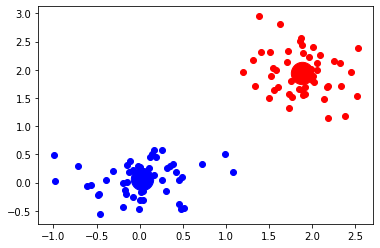

In [50]:
data_class = dispatch(data, center)
c0 = data_class == 0
c1 = data_class == 1
plt.scatter(data[c0, 0], data[c0, 1], c="b")
plt.scatter(data[c1, 0], data[c1, 1], c="r")
plt.scatter(center[0, 0], center[0, 1], c="b", s=500)
plt.scatter(center[1, 0], center[1, 1], c="r", s=500)